In [1]:
import featurization
import helpers

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%reload_ext autoreload
%autoreload 2

First let's look at the raw training data we've collected. The plot below shows the number of available bicycles at every minute for about a week and a half, and the two below that show a single weekday and a single weekend day. Peaks indicate times when many bicycles are available/few bikes are bing used. A few observations:
- the highest bike usage (lowest availability) is in mid to late afternoon.
- there doesn't appear to be a particular "morning commute" like is seen in many cities.
- overnight availability probably indicates the total number of bikes in the system that day, since few people ride at night. The variations in overnight availability are probably related to how many bikes break in a day, or possibly need charging (though I think charging may be done on site by swapping out a battery pack).
- generally more people ride on the weekends (10/26 and 10/27) than on weekdays.
- a lot of bikes seem to have gone out of service after a day of heavy usage on 10/27 (note how few bikes are available in the system that night).

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


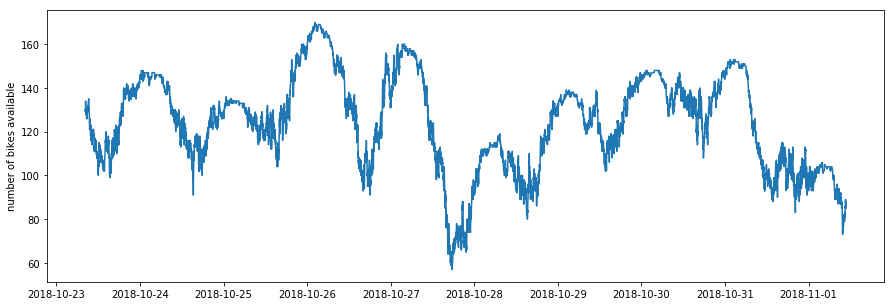

In [2]:
df = featurization.import_and_clean_data("bike-data/all-sc-bike-data-1101.csv")
df['local_time'] = df['utc_time'].dt.tz_convert('America/Los_Angeles')
at_a_time = df.groupby(by='local_time')
at_a_time = at_a_time.bike_id.count().reset_index()
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(at_a_time['local_time'], at_a_time['bike_id'])
plt.ylabel('number of bikes available')
plt.show()

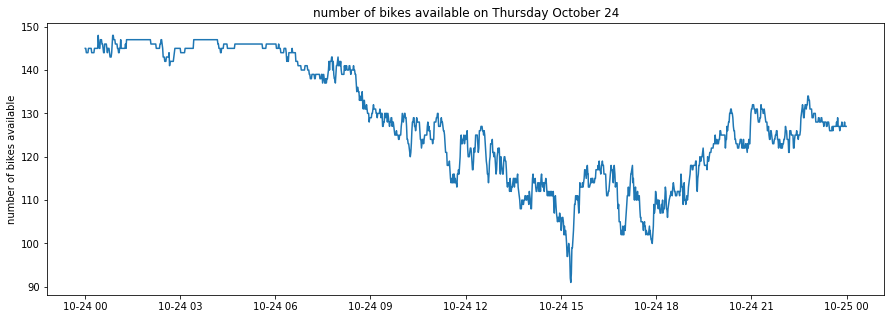

In [3]:
one_weekday = at_a_time[(at_a_time['local_time']>'2018-10-24') & (at_a_time['local_time']<'2018-10-25')]
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(one_weekday['local_time'], one_weekday['bike_id'])
plt.ylabel('number of bikes available')
plt.title('number of bikes available on Thursday October 24')
plt.show()

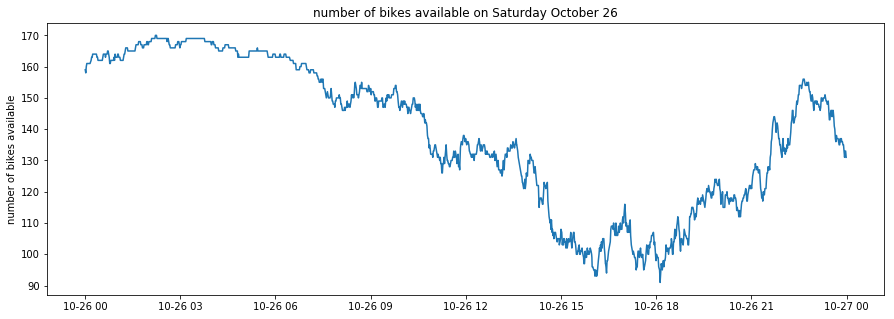

In [4]:
one_weekend = at_a_time[(at_a_time['local_time']>'2018-10-26') & (at_a_time['local_time']<'2018-10-27')]
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(one_weekend['local_time'], one_weekend['bike_id'])
plt.ylabel('number of bikes available')
plt.title('number of bikes available on Saturday October 26')
plt.show()

Now lets look at the data once it's been processed from individual bike availabilities at every minute (the raw form from the API), and transformed into "idle events" - each datapoint is now one bike at one location, for some period of time that it sits idle. The all_featurization method also adds in some other interesting features, as we'll see.

In [3]:
geodf = featurization.all_featurization("bike-data/all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


So how long do bikes sit idle for? On average, 2.8 hours, or a median time of 0.8 hours. At most, 118 hours (nearly 5 days).

In [7]:
geodf.idle_hours.describe()

count    7098.000000
mean        2.835200
std         5.352362
min         0.000278
25%         0.232153
50%         0.804722
75%         2.663819
max       118.493611
Name: idle_hours, dtype: float64

### Mapping bike idle times
Let's see this on a map - where do bikes sit for the longest? I'm trimming this to just bikes that sit idle for less than 35 hours, to have a meaningful color ramp. There are only a small handful of bikes that sit longer than this. 

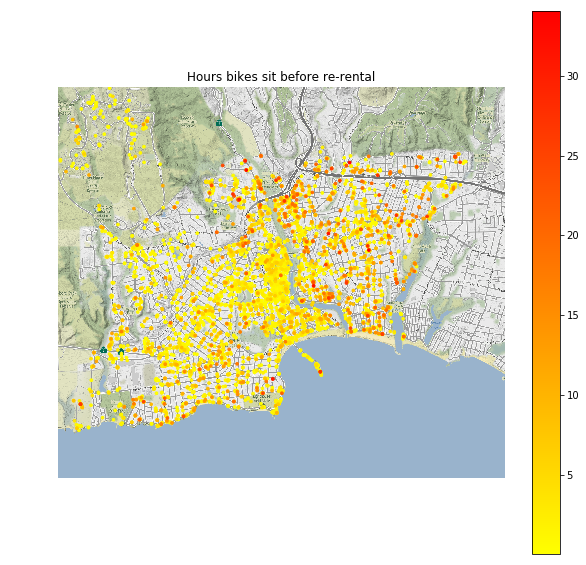

In [4]:
geodf_clean = geodf[geodf['idle_hours']<35]
geodf_clean = geodf_clean.sort_values('idle_hours')
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = helpers.map_bikes(ax, geodf_clean, zoom=15, column='idle_hours', legend = True, cmap='autumn_r', s=7)
plt.title('Hours bikes sit before re-rental')
plt.show()

### Counting idle times
Here's a histogram of all idle events. Looks like most bikes don't sit for long at all - probably under half an hour!

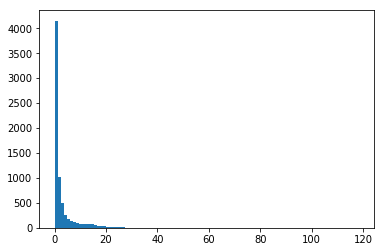

In [75]:
plt.hist(geodf.idle_hours, bins=100)
plt.show()

### Mean idle time mapped by census blockgroup. 
Looks like the east side of the city, which is more residential, has some of the longest idle times. The brightest yellow in the center of the map is downtown, and the northwest corner is the UC Santa Cruz campus. The southwest corner is also resdiential, but bikes don't sit as long there as they do on the west side.

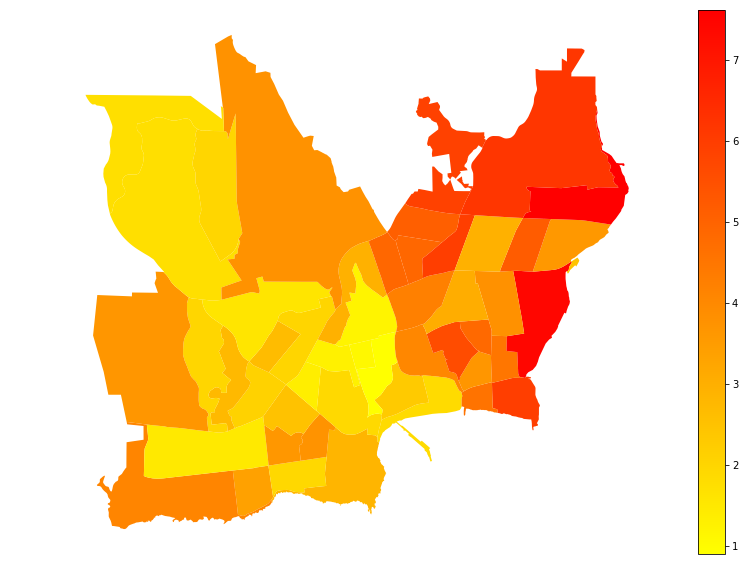

In [34]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_mean_idles = blockgrouped.idle_hours.mean()
bg_mean_idles = bg_mean_idles.reset_index()
bg_mean_idles = bg_mean_idles[bg_mean_idles.idle_hours <12]
bg_mean_idles = helpers.add_blockgroup_geometry(bg_mean_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_mean_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='autumn_r')
ax.axis('off')
plt.show()

### Median idle time by census blockgroup. 
Similar patterns as seen in the mean times.

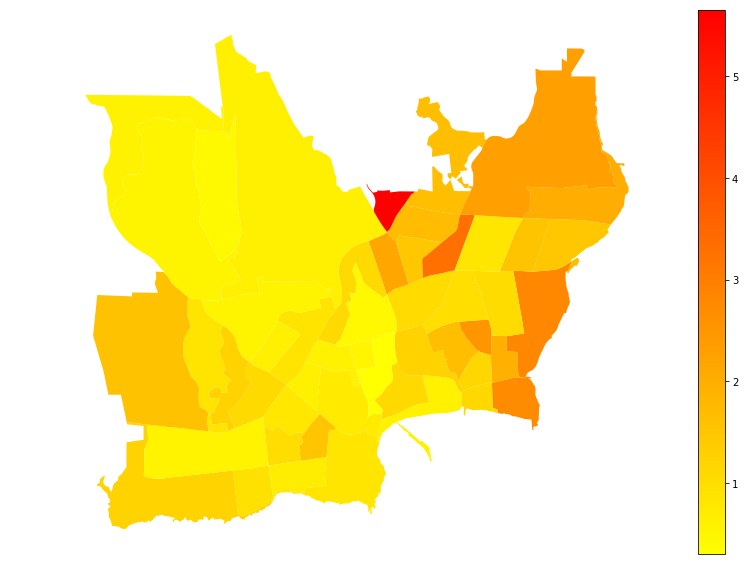

In [4]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_med_idles = blockgrouped.idle_hours.median()
bg_med_idles = bg_med_idles.reset_index()
bg_med_idles = helpers.add_blockgroup_geometry(bg_med_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_med_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='autumn_r')
ax.axis('off')
plt.show()

In [10]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_counts = blockgrouped.bike_id.count()
bg_counts = bg_counts.reset_index()
bg_counts.rename(mapper={'bike_id':'rentals'}, axis=1, inplace=True)
bg_pop = blockgrouped.population.mean()
bg_counts = bg_counts.join(bg_pop, on='GEOID_Data')
bg_counts['rentals_per_pop'] = bg_counts['rentals']/bg_counts['population']/10
bg_counts = helpers.add_blockgroup_geometry(bg_counts)

### Number of rentals per capita each day

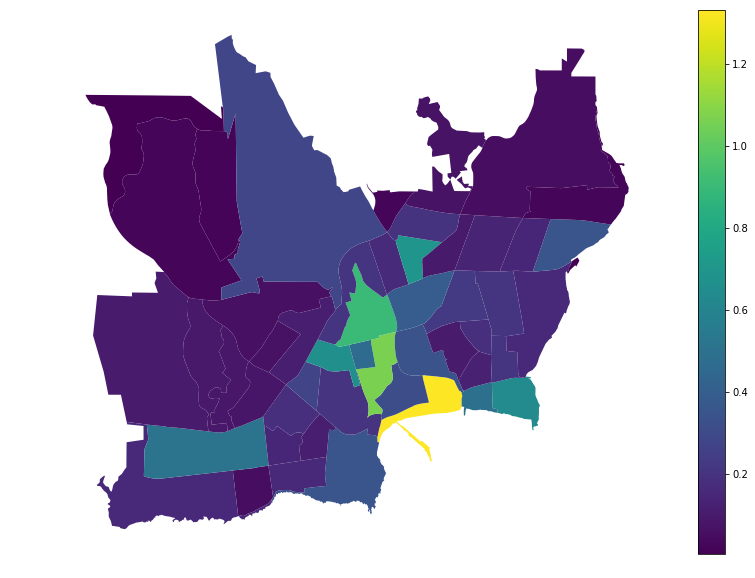

In [11]:
fig, ax = plt.subplots(1, figsize=(15, 10))
bg_counts.plot(ax = ax, column='rentals_per_pop', legend = True, cmap='viridis')
ax.axis('off')
plt.show()

### Total number of rentals in each blockgroup over 9 days.

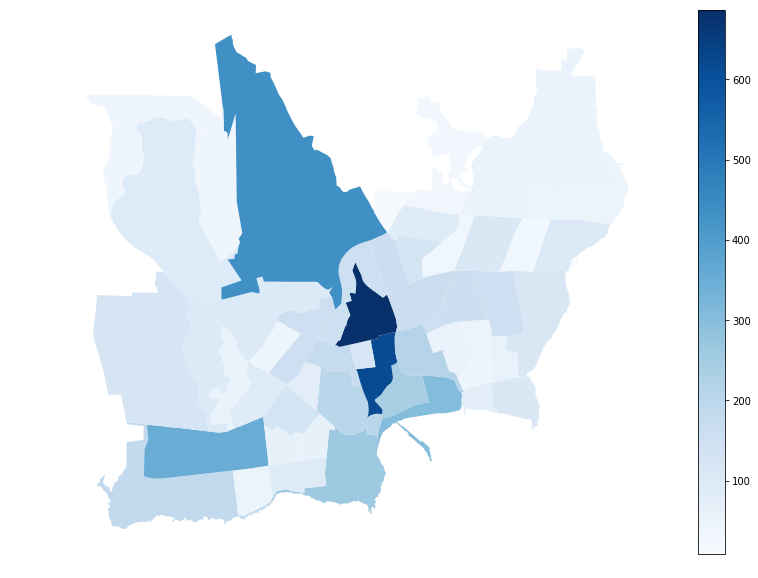

In [186]:
fig, ax = plt.subplots(1, figsize=(15, 10))
bg_counts.plot(ax = ax, column='rentals', legend = True, cmap='Blues')
ax.axis('off')
plt.show()

### Counts of bikes by time of day and location
The heatmap below shows that the most bikes are observed in just a couple of census blockgroups, and that bike usage peaks in the early afternoon. (The "counts" are the number of bikes parked in that location within that hour of the day).

In [45]:
grouped = geodf.groupby(by=['GEOID_Data', 'time_of_day_start'], axis=0)
counts = grouped['bike_id'].count().reset_index()
counts = counts.pivot(index='GEOID_Data', columns='time_of_day_start', values='bike_id')

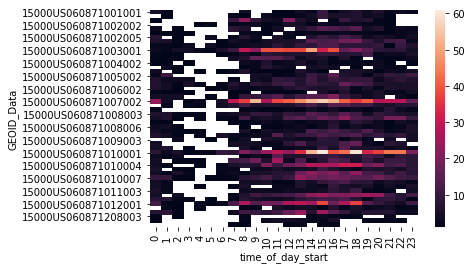

In [46]:
sns.heatmap(counts, )

The heatmap below shows the count of bikes by day of week and time of day for a single week. Looks like some of the heaviest usage is weekday afernoons (days 0-4). Weekends have more usage into the small hours of the morning.

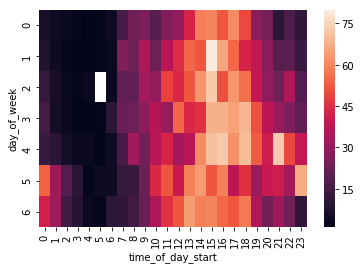

In [12]:
one_week = geodf[(geodf['local_time_start']>'2018-10-24') & (geodf['local_time_start']<'2018-10-31')]
grouped = one_week.groupby(by=['day_of_week', 'time_of_day_start'], axis=0)
counts = grouped['bike_id'].count().reset_index()
counts = counts.pivot(index='day_of_week', columns='time_of_day_start', values='bike_id')
sns.heatmap(counts)

### City zoning map

In [112]:
zoningdf = geopandas.read_file('geospatial_data/Zoning')

In [119]:
zoningdf = geopandas.read_file('geospatial_data/Zoning')
zoningdf['zoning_simp'] = zoningdf['ZONING'].str.slice(0,1)
zoningdf = zoningdf.replace(['R', 'C', 'P', 'O', 'F', 'I', 'E'], ['residential', 'commercial', 'public', 'ocean', 'floodplain', 'industrial', 'agricultural'])
zoningdf.loc[zoningdf['ZONING'] == 'PA', 'zoning_simp'] = 'office'

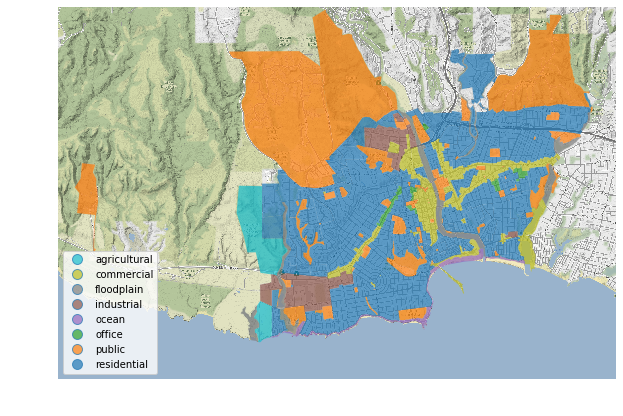

In [191]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
helpers.map_bikes(ax, zoningdf, column='zoning_simp', alpha=0.7, legend=True, cmap='tab10_r', legend_kwds={'loc':'lower left'})
plt.show()

### Bikes by city zone
The map below has colored each idle bike by the city zone it sits in. There are a lot more bikes in the commercial districts than in other areas.

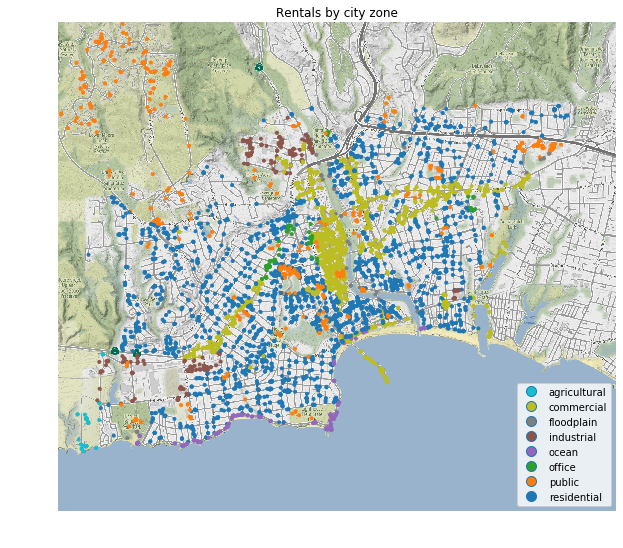

In [180]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = helpers.map_bikes(ax, geodf, zoom=15, column='zoning_simp', legend = True, cmap='tab10_r', s=9)
plt.title('Rentals by city zone')
plt.show()

### Bikes by population density
The map below colors each idle bike by the population density of the census blockgroup that it sits in. There doesn't seem to be a strong pattern here.

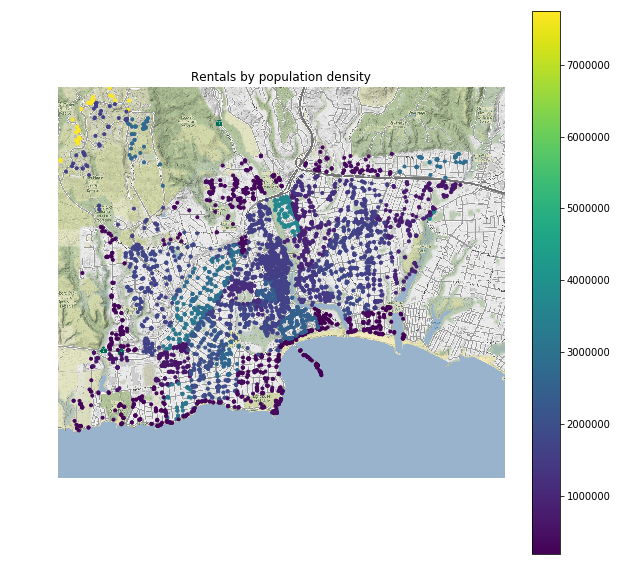

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = helpers.map_bikes(ax, geodf, zoom=15, column='pop_density', legend = True, cmap='viridis', s=9, legend_kwds={'markerscale':0.7})
plt.title('Rentals by population density')
plt.show()

### Post-charging bike locations
Where do bikes end up after being charged? Pretty much all over the place. This map shows only the bikes that were just charged (where this idle event has a higher battery level than the previous idle event). This might mean that charged bikes are getting dropped off all over the place, or this might mean that charging is happening "in-place", like by a battery swap-out rather than by being taken somewhere to be plugged in.

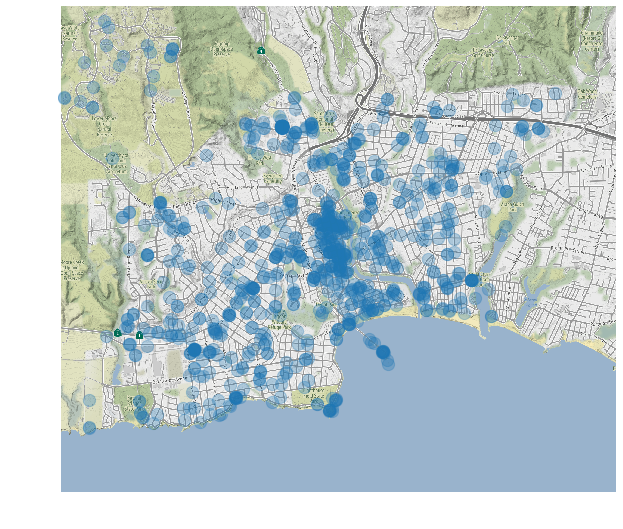

In [80]:
just_charged = geodf[geodf['just_got_charged']]
fig, ax = plt.subplots(1,1, figsize=(10,10))
helpers.map_bikes(ax, just_charged, alpha=0.3, markersize=150)
plt.show()

### Bike movement throughout the day
The series of figures below show the net flow of bikes in and out of each blockgroup, by time of day. Net flow is defined as number of bikes arriving minus number of bikes departing. This is an example for just one day, October 29.

In [39]:
geodf_one = geodf[pd.to_datetime(geodf.local_time_start.dt.date) == '2018-10-29']

In [44]:
timeofday_start = geodf_one.groupby(by=['GEOID_Data', 'time_of_day_start'], axis=0)
timeofday_end = geodf_one.groupby(by=['GEOID_Data', 'time_of_day_end'], axis=0)

stod = timeofday_start.bike_id.count().unstack(fill_value=0).stack().reset_index(name='count')
etod = timeofday_end.bike_id.count().unstack(fill_value=0).stack().reset_index(name='count')

stod['net_flow'] = stod['count']-etod['count']
stod.rename(mapper = {'count':'arrivals'}, axis=1, inplace=True)
stod['departures'] = etod['count']

btod = helpers.add_blockgroup_geometry(stod)
btod = btod.fillna(0)

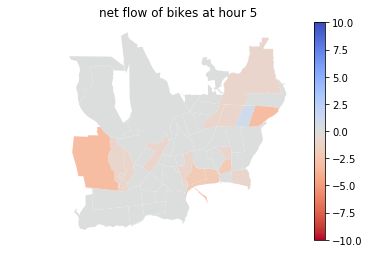

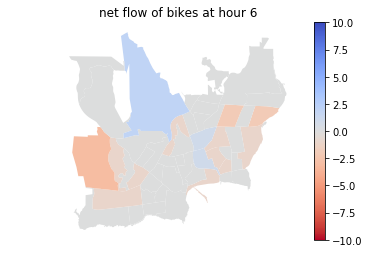

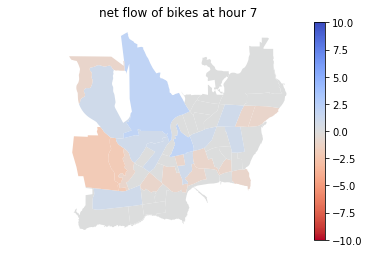

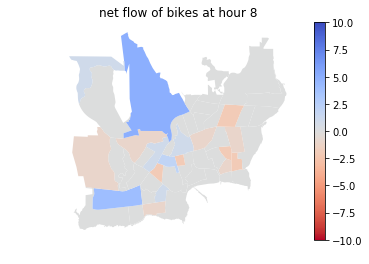

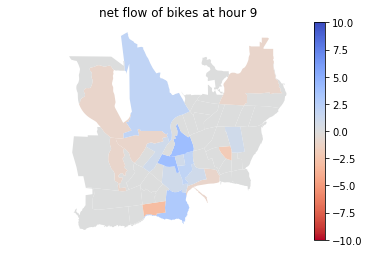

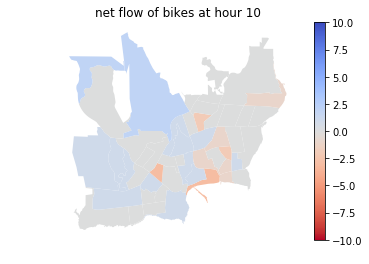

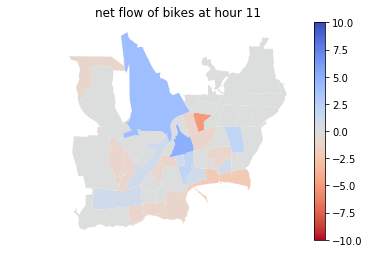

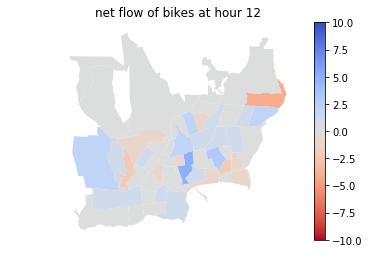

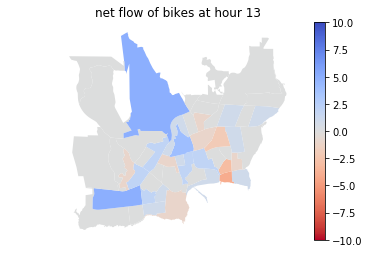

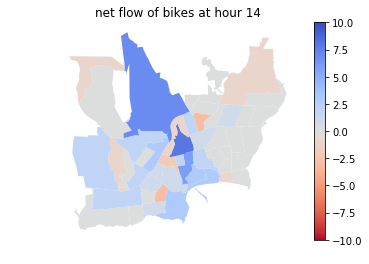

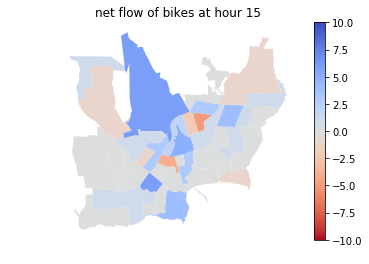

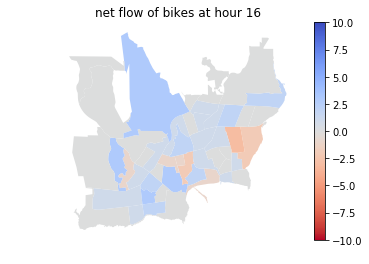

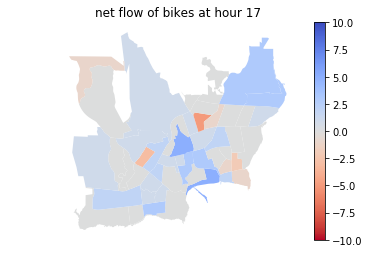

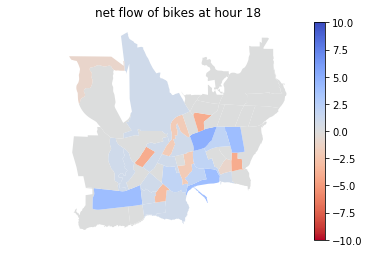

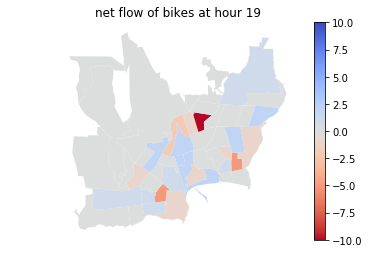

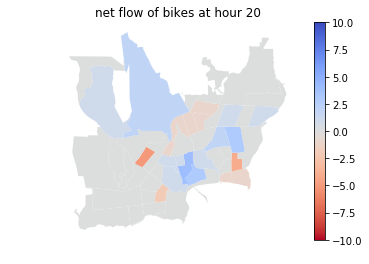

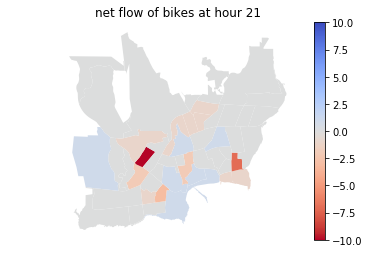

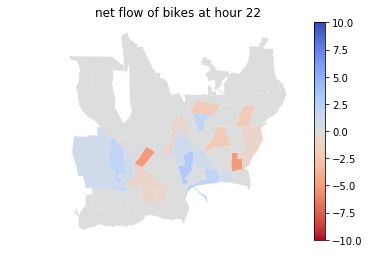

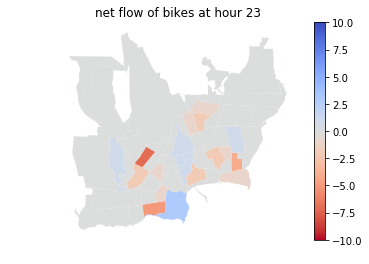

In [54]:
for hour in range(5,24):
    hourly_flow = btod[btod.time_of_day_start == hour]
    hourly_flow.plot(column='net_flow', legend = True, cmap='coolwarm_r', vmin=-10, vmax=10)
    plt.title('net flow of bikes at hour {}'.format(hour))
    plt.axis('off')
    plt.savefig('img_flow_hr_{}'.format(hour))

The below shows just the arrivals by hour of the day - these are the destinations where bikes are being dropped off.

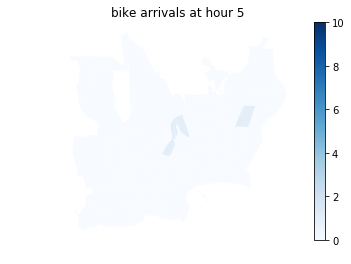

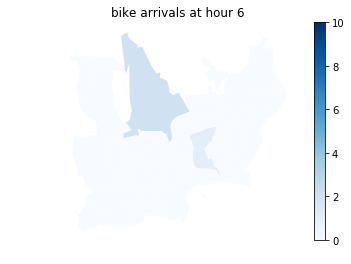

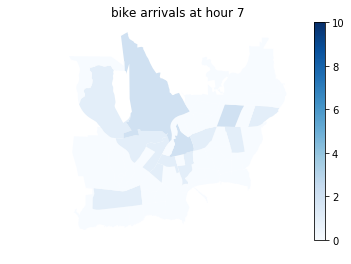

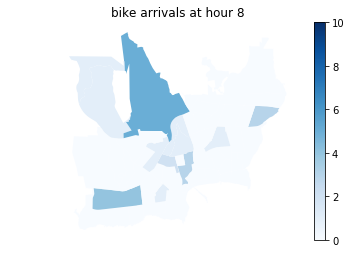

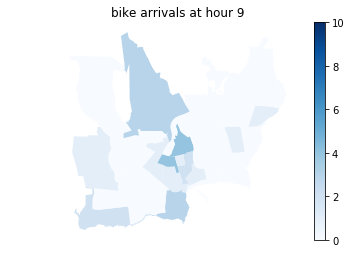

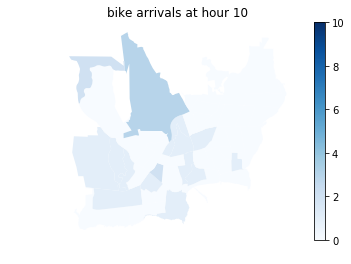

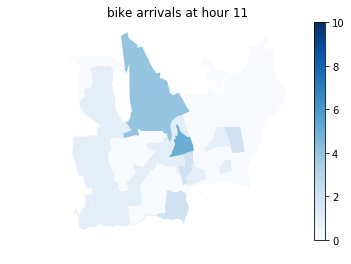

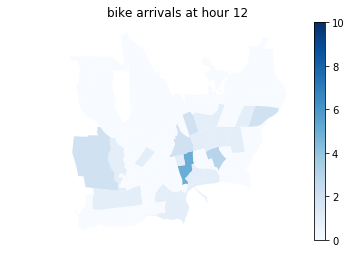

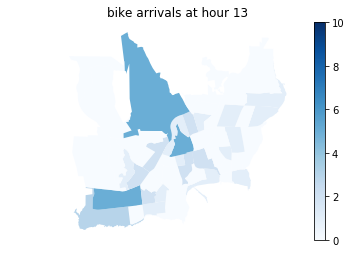

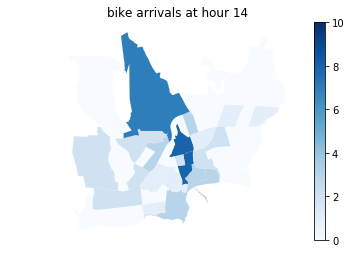

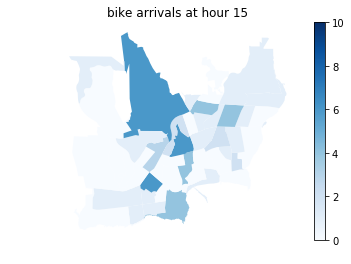

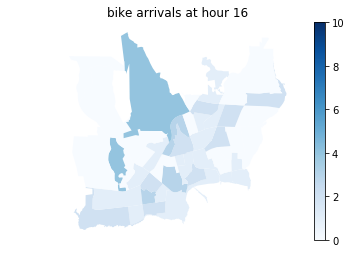

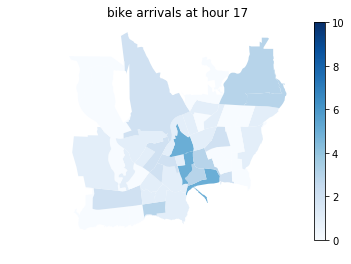

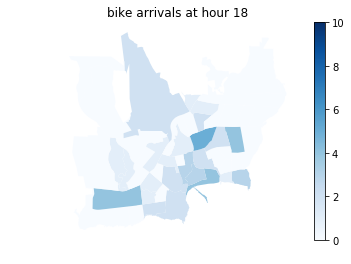

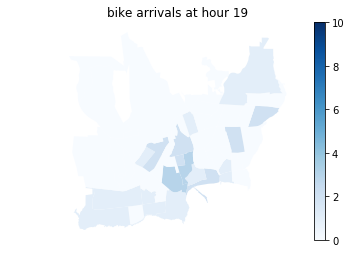

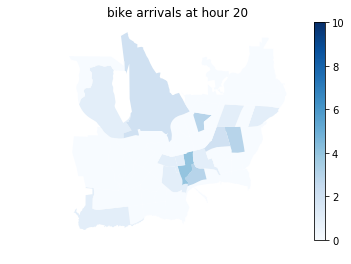

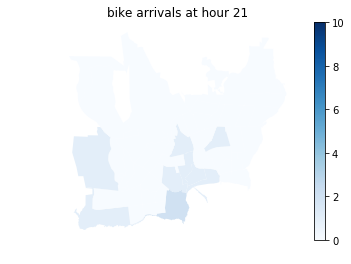

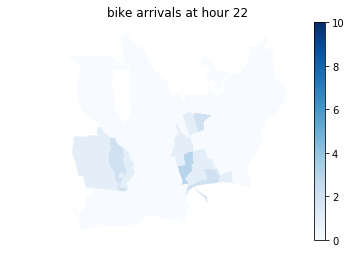

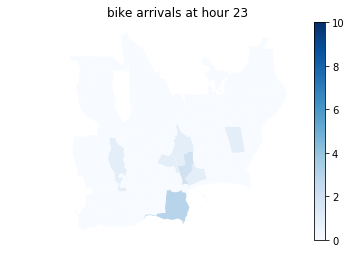

In [193]:
for hour in range(5,24):
    hourly_flow = btod[btod.time_of_day_start == hour]
    hourly_flow.plot(column='arrivals', legend = True, cmap='Blues', vmin=0, vmax=10)
    plt.title('bike arrivals at hour {}'.format(hour))
    plt.axis('off')
    plt.savefig('img_arrival_hr_{}'.format(hour))

### Distribution of idle times
The histograms below show the number of bikes (y-axis) that sit for various idle times (x-axis), for each census blockgroup. Each shows an exponential distribution of bike departures, though the rate (beta parameter) of that distribution varies by blockgroup. This is the same pattern we observed earlier for the city as a whole.

The exponential distribution shows us that the outlier bikes - those ones that sit for an unusually long time - can be found everywhere (and at every time - see similar histograms for time of day and day of week further down)

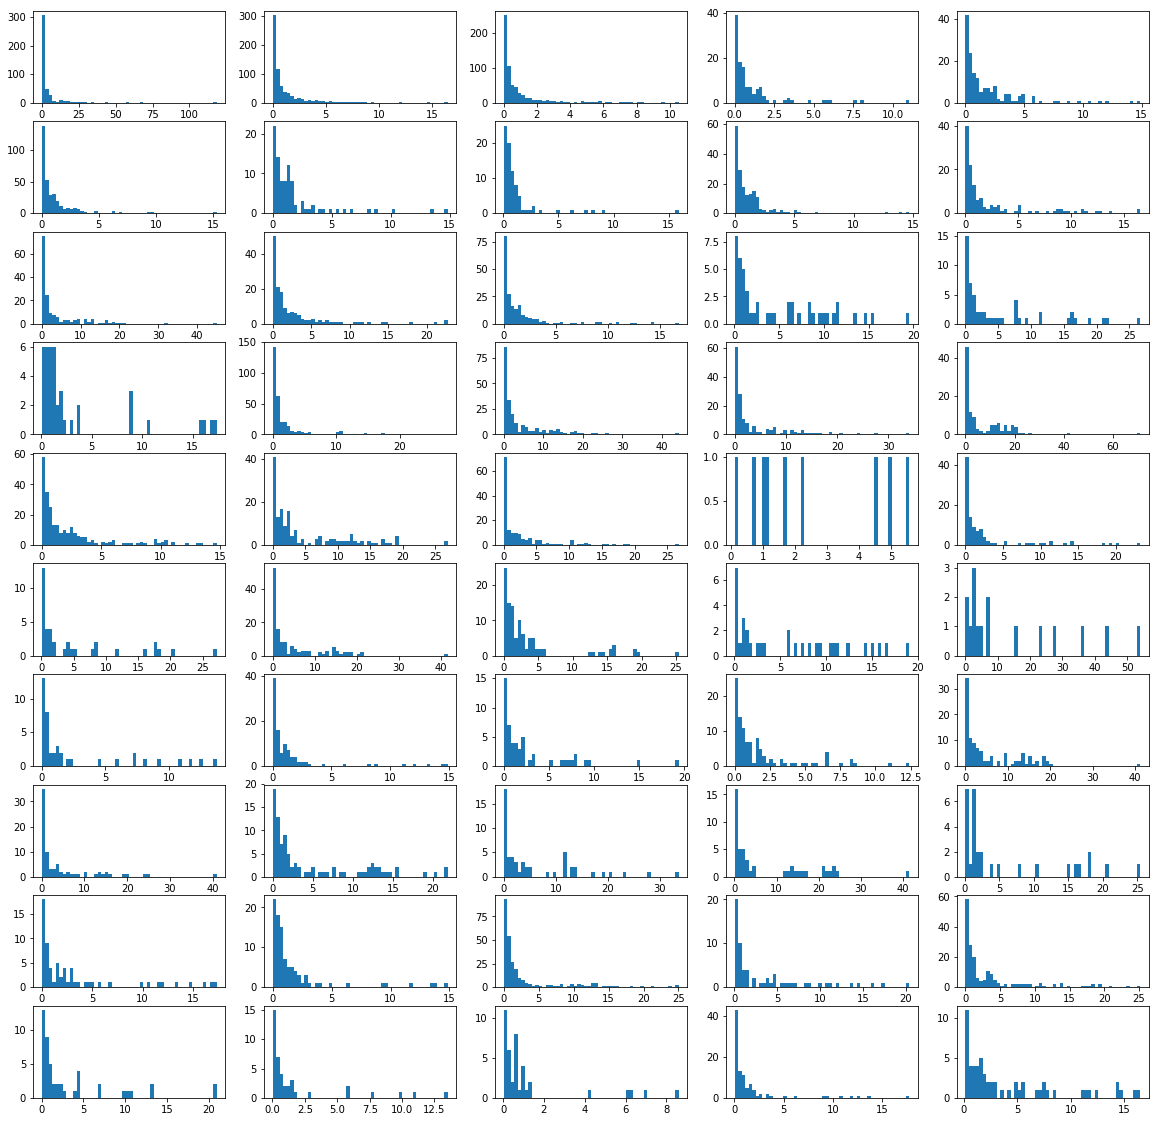

In [39]:
blockgroups = geodf.GEOID_Data.unique()

fig, axes = plt.subplots(10, 5, figsize = (20,20))
for bg, a in zip(blockgroups, axes.reshape(-1)):
    a.hist(geodf[geodf.GEOID_Data == bg].idle_hours, bins=50)

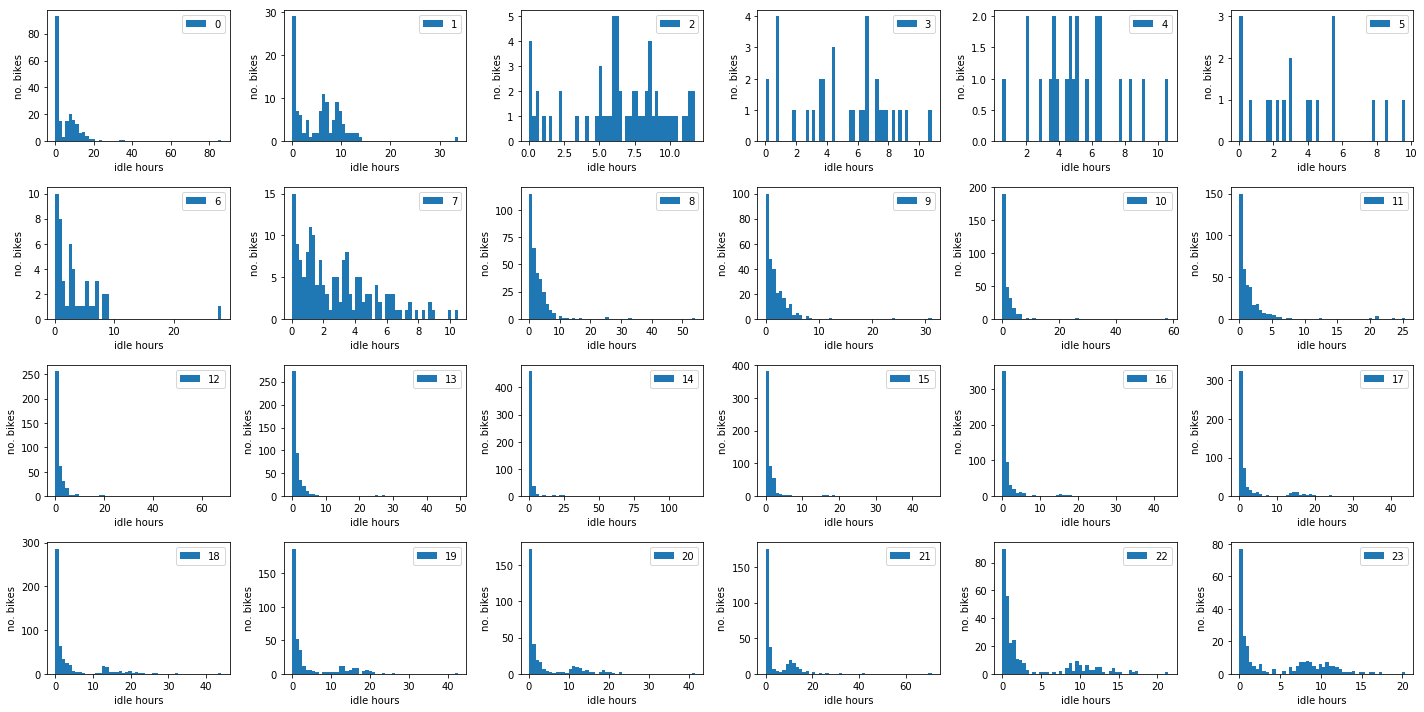

In [29]:
hours = sorted(geodf.time_of_day_start.unique())

fig, axes = plt.subplots(4, 6, figsize = (20,10))
for h, a in zip(hours, axes.reshape(-1)):
    a.hist(geodf[geodf.time_of_day_start == h].idle_hours, bins=50, label=h)
    a.legend()
    a.set(xlabel="idle hours", ylabel="no. bikes")
plt.tight_layout()
plt.show()

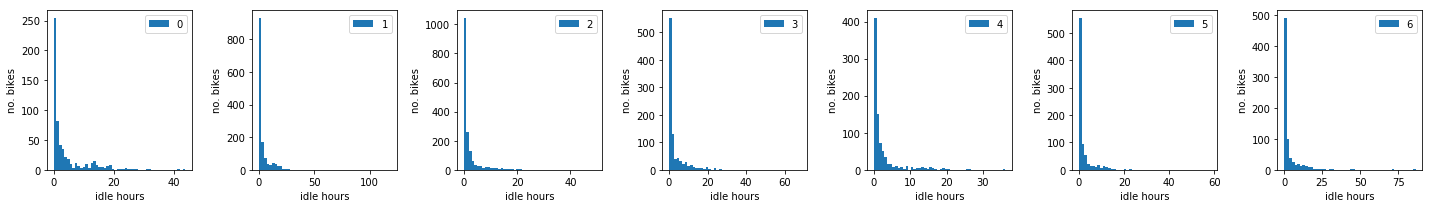

In [33]:
days = sorted(geodf.day_of_week.unique())

fig, axes = plt.subplots(1, 7, figsize = (20,3))
for d, a in zip(days, axes.reshape(-1)):
    a.hist(geodf[geodf.day_of_week == d].idle_hours, bins=50, label=d)
    a.legend()
    a.set(xlabel="idle hours", ylabel="no. bikes")
plt.tight_layout()
plt.show()